### Data augmentation of character images for training of classification model

In [12]:
import os
import sys
import numpy as np
import pandas as pd
import cv2
import random

from matplotlib import pyplot as plt
import seaborn as sns

import imgaug as ia
import imgaug.augmenters as iaa
from skimage.transform import swirl

import inspect as i

In [13]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
img_folder = r'/home/hkolstee/uniprojects/hwRecog/data/monkbrill'
output_path = r'/home/hkolstee/uniprojects/hwRecog/data/monkbrill_augm'

## Data preparation

In [14]:
def create_dataset(img_folder):
   
    img_data_array= []
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path = os.path.join(img_folder, dir1,  file)
            image = cv2.imread(image_path, -1)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            # if image is not grayscale
            if (image.shape != (28, 28)):
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # invert
            image = cv2.bitwise_not(image)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
            
    return img_data_array, class_name

In [15]:
# image array and class name
img_data, class_name = create_dataset(img_folder)

x = np.array(img_data, dtype = np.float32)

## Data observation

In [16]:
classes, counts = np.unique(class_name, return_counts = True)

data_dict = {}
for (key, value) in zip(classes, counts):
    data_dict[key] = value
    
print(f"Unique classes and number of images:")
data_dict

Unique classes and number of images:


{'Alef': 300,
 'Ayin': 300,
 'Bet': 300,
 'Dalet': 91,
 'Gimel': 300,
 'He': 300,
 'Het': 300,
 'Kaf': 193,
 'Kaf-final': 10,
 'Lamed': 294,
 'Mem': 300,
 'Mem-medial': 300,
 'Nun-final': 130,
 'Nun-medial': 300,
 'Pe': 37,
 'Pe-final': 15,
 'Qof': 265,
 'Resh': 78,
 'Samekh': 300,
 'Shin': 300,
 'Taw': 300,
 'Tet': 300,
 'Tsadi-final': 73,
 'Tsadi-medial': 300,
 'Waw': 116,
 'Yod': 23,
 'Zayin': 12}

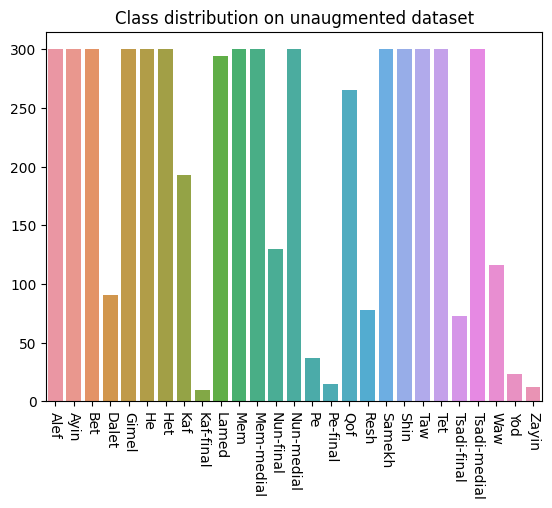

In [17]:
df = pd.DataFrame(data_dict, index=[0])
fig = sns.barplot(df)
fig.set_xticklabels(fig.get_xticklabels(), rotation=-90, horizontalalignment='center')
fig.set(title="Class distribution on unaugmented dataset")
plt.show()

### Example images

In [18]:
def display_images(image_list, title):
    nr_images = len(image_list)
    
    # size of x axis in grid
    x = int(np.floor(np.sqrt(nr_images)))
    # size of y axis in grid
    y = int(np.ceil(nr_images/x))
    
    fig, axs = plt.subplots(x, y)
    axs = axs.flatten()
    for (image, ax) in zip(image_list, axs):
        ax.imshow(image, cmap = "Greys")
    
    fig.suptitle(title)
    plt.show()

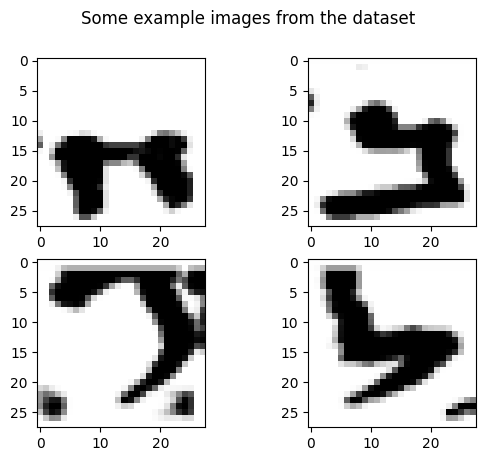

In [19]:
images = []
for image_class in classes[6:10]:
    images.append(img_data[class_name.index(image_class)])
display_images(images, "Some example images from the dataset")    

## Data augmentation   
We will be using the package **imgaug**.   
Data is still ***img_data*** and ***class_name***.

### Augmentations:
- Rotate
- Scale
- Gaussian noise
- Shear (X/Y)
- Translate (X/Y)
- Swirl
- Elastic transform
- Random erase


In [20]:
def rotate_image(input_img, rotation):
    rot = iaa.Affine(rotate = rotation)
    rotated_img = rot.augment_image(input_img)
    return rotated_img

def scale_image(input_img, percent):
    scale = iaa.Affine(scale = percent)
    scaled_img = scale.augment_image(input_img)
    return scaled_img

def gaussian_noise(input_img, std_of_normal):
    noise = iaa.AdditiveGaussianNoise(scale = std_of_normal)
    noisy_img = noise.augment_image(input_img)
    return noisy_img

def shearX_image(input_img, degree):
    shear = iaa.ShearX(shear = degree)
    sheared_img = shear.augment_image(input_img)
    return sheared_img

def shearY_image(input_img, degree):
    shear = iaa.ShearY(shear = degree)
    sheared_img = shear.augment_image(input_img)
    return sheared_img

def translateX(input_img, percent):
    tX = iaa.TranslateX(percent = percent)
    tX_img = tX.augment_image(input_img)
    return tX_img

def translateY(input_img, percent):
    tY = iaa.TranslateY(percent = percent)
    tY_img = tY.augment_image(input_img)
    return tY_img

def swirl_image(input_img, rotation, strength, radius):
    swirled_img = swirl(input_img, rotation = rotation, strength = strength, radius = radius)
    return swirled_img

def elastic_transform(input_img, alpha, sigma):
    elastic = iaa.ElasticTransformation(alpha = alpha, sigma = sigma)
    elastic_img = elastic.augment_image(input_img)
    return elastic_img

# randomly erases a block of about 10% of the image
def random_erase(input_img):
    # create output img
    output_img = np.copy(input_img)
    
    # get x and y coords
    randomX1 = random.uniform(0., 0.7)
    randomX2 = random.uniform(randomX1+0.15, 1.0)
    randomY1 = random.uniform(0., 0.7)
    randomY2 = (0.1 / (abs(randomX1 - randomX2))) + randomY1

    # loop over pixels to erase
    for i in range(round(randomX1*27), round(randomX2*27)):
        for j in range(round(randomY1*27), min(round(randomY2*27), 28)):
            output_img[i][j] = 0.
    
    return output_img

In [21]:
def random_augment(input_img, nr_of_augments):
    # list of functions
    functions = [lambda x : rotate_image(x, -15), lambda x : rotate_image(x, 15), lambda x : scale_image(x, 0.8), lambda x : scale_image(x, 1.2), 
                lambda x : gaussian_noise(x, 0.075), lambda x : shearX_image(x, 30), lambda x : shearX_image(x, -30), 
                lambda x : shearY_image(x, 30), lambda x : shearY_image(x, -30), lambda x : translateX(x, 0.1), 
                lambda x : translateX(x, -0.1), lambda x : translateY(x, 0.1), lambda x : translateY(x, -0.1), 
                lambda x : swirl_image(x, rotation = -0.3, strength = -2, radius = 30), 
                lambda x : swirl_image(x, rotation = 0.3, strength = 2, radius = 30), lambda x : random_erase(x),
                lambda x : elastic_transform(x, 50, 8)]
    
    # copy input img
    output_img = np.copy(input_img)
    # apply augments
    for i in range(nr_of_augments):
        output_img = random.choice(functions)(output_img)
        
    return output_img    

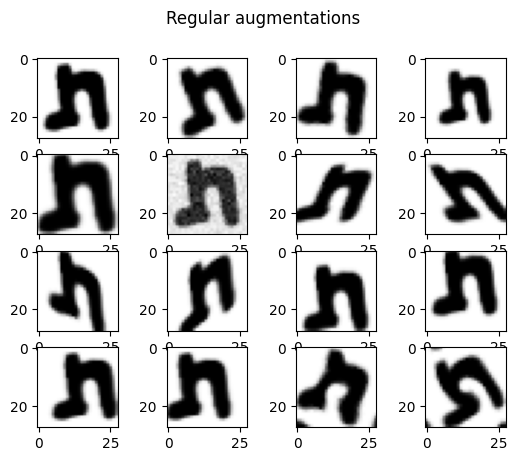

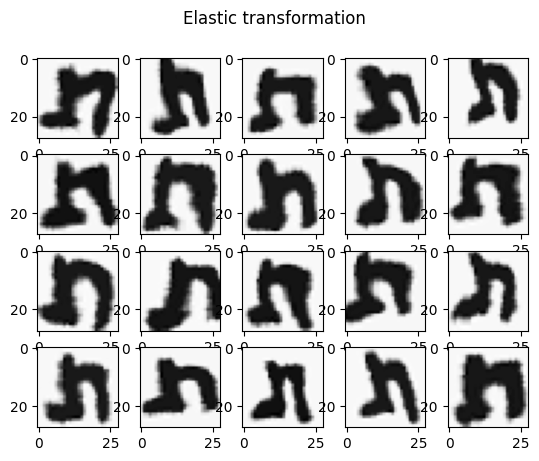

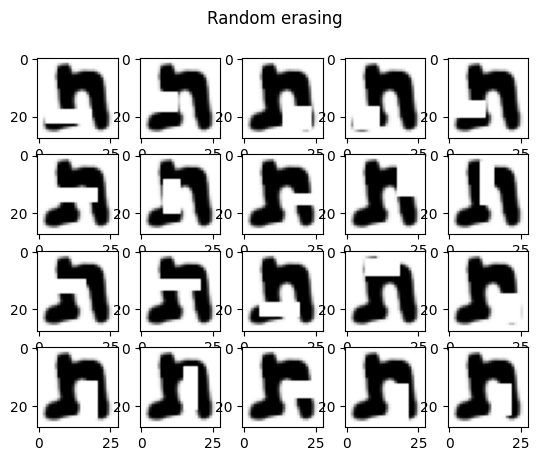

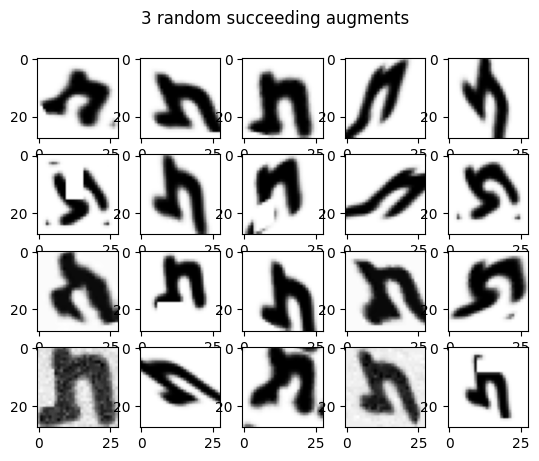

In [22]:
regular_augment_imgs = []
elastic_imgs = []
random_erase_imgs = []
random_augments_imgs = []
# we will be using image 2005 to showcase the augmentations
input_img = img_data[2005]

# augmentations
rotated_img1 = rotate_image(input_img, -15)
rotated_img2 = rotate_image(input_img, 15)
scaled_img1 = scale_image(input_img, 0.8)
scaled_img2 = scale_image(input_img, 1.2)
gaussian_noise_img = gaussian_noise(input_img, 0.075)
shearedX_img1 = shearX_image(input_img, 30)
shearedX_img2 = shearX_image(input_img, -30)
shearedY_img1 = shearY_image(input_img, 30)
shearedY_img2 = shearY_image(input_img, -30)
translateX_img1 = translateX(input_img, 0.1)
translateX_img2 = translateX(input_img, -0.1)
translateY_img1 = translateY(input_img, 0.1)
translateY_img2 = translateY(input_img, -0.1)
swirled_image1 = swirl_image(input_img, rotation = -0.3, strength = -2, radius = 30)
swirled_image2 = swirl_image(input_img, rotation = 0.3, strength = 2, radius = 30)

# append and display
regular_augment_imgs.append(input_img)
regular_augment_imgs.append(rotated_img1)
regular_augment_imgs.append(rotated_img2)
regular_augment_imgs.append(scaled_img1)
regular_augment_imgs.append(scaled_img2)
regular_augment_imgs.append(gaussian_noise_img)
regular_augment_imgs.append(shearedX_img1)
regular_augment_imgs.append(shearedX_img2)
regular_augment_imgs.append(shearedY_img1)
regular_augment_imgs.append(shearedY_img2)
regular_augment_imgs.append(translateY_img1)
regular_augment_imgs.append(translateY_img2)
regular_augment_imgs.append(translateX_img1)
regular_augment_imgs.append(translateX_img2)
regular_augment_imgs.append(swirled_image1)
regular_augment_imgs.append(swirled_image2)
display_images(regular_augment_imgs, "Regular augmentations")

# showcase elastic transformation
for i in range(20):
    image = elastic_transform(input_img, 50, 8)
    elastic_imgs.append(image)
display_images(elastic_imgs, "Elastic transformation")

# showcase random erase
for i in range(20):
    image = random_erase(input_img)
    random_erase_imgs.append(image)
display_images(random_erase_imgs, "Random erasing")

# showcase 3 random augments in succession
for i in range(20):
    image = random_augment(input_img, 3)
    random_augments_imgs.append(image)
display_images(random_augments_imgs, "3 random succeeding augments")

### Transform the dataset